In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [397]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [398]:
data = pd.read_csv('final-data.csv')

In [399]:
data['Week Endings'] = pd.to_datetime(data['Week Endings'], errors = 'raise')
data = data.sort_values(by='Week Endings', ascending=True)

In [400]:
# Truncating data after the release of the lion king movie
lk_release = datetime.date(2019, 7, 19)
boolean_mask = data['Week Endings'].dt.date < lk_release

In [401]:
# Data after the series has been truncated
print(data[boolean_mask].tail(5).to_string())
print(data[boolean_mask].shape)

    Week Endings  Avg Ticket Price ($)  Top Ticket Price ($)  Seats Sold  Seats in Theatre   % Cap
141   2019-06-16                171.79                 225.0       13565              1696   99.98
140   2019-06-23                178.53                 225.0       13569              1696  100.01
139   2019-06-30                179.18                 225.0       13550              1696   99.87
138   2019-07-07                190.91                 225.0       13519              1696   99.64
137   2019-07-14                187.67                 225.0       12759              1696   94.04
(1129, 6)


In [402]:
data = data[boolean_mask]

In [403]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1129 entries, 1265 to 137
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Week Endings          1129 non-null   datetime64[ns]
 1   Avg Ticket Price ($)  1129 non-null   float64       
 2   Top Ticket Price ($)  1129 non-null   float64       
 3   Seats Sold            1129 non-null   int64         
 4   Seats in Theatre      1129 non-null   int64         
 5   % Cap                 1129 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 61.7 KB


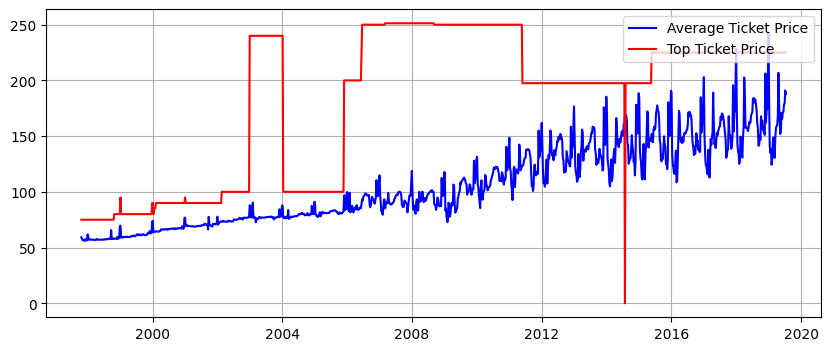

In [404]:
# Some basic plotting to check data and 
# data scale to determine whether data needs to be normalised or not
# before being used with the sequence model for prediction
# year = np.array(range(data.shape[0])) + 757
time = data['Week Endings']
plt.figure(figsize=(10, 4))
plt.grid(True)
plt.plot(time, data['Avg Ticket Price ($)'], color='b', label="Average Ticket Price")
plt.plot(time, data['Top Ticket Price ($)'], color='r', label="Top Ticket Price")
plt.legend(loc=1)
plt.show()

In [405]:
series = data['Avg Ticket Price ($)']
split_time = int(len(series) * 0.85)

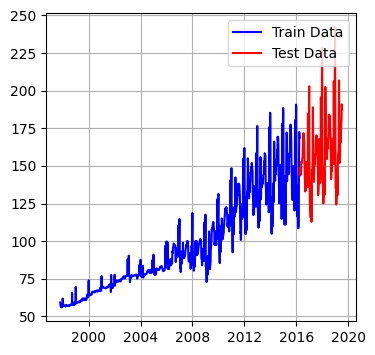

In [406]:
x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

plt.figure(figsize=(4, 4))
plt.grid(True)
plt.plot(time_train, x_train, color='b', label="Train Data")
plt.plot(time_valid, x_valid, color='r', label="Test Data")
plt.legend(loc=1)
plt.show()

# Utilities:

In [407]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [408]:
# Defining parameters
window_size = 48
batch_size = 12
shuffle_buffer = 1000

In [409]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [410]:
# Checking the windowed training set:
list(train_set.take(2).as_numpy_iterator())

[(array([[ 57.66,  57.28,  57.68,  57.52,  57.63,  57.69,  58.04,  57.88,
           57.66,  65.67,  57.74,  57.96,  58.13,  57.72,  57.93,  57.97,
           58.1 ,  57.81,  57.82,  59.63,  57.91,  58.56,  58.38,  69.05,
           69.64,  59.22,  58.78,  59.39,  59.26,  59.46,  59.46,  59.37,
           59.63,  59.39,  59.67,  59.87,  59.36,  59.42,  59.62,  59.47,
           60.15,  60.2 ,  60.45,  60.61,  60.85,  60.19,  60.14,  60.48],
         [ 70.25,  71.27,  70.51,  70.84,  70.85,  70.79,  70.73,  66.22,
           77.59,  71.09,  70.52,  69.78,  69.66,  69.13,  68.81,  71.32,
           71.04,  71.33,  71.24,  70.77,  71.29,  71.93,  77.69,  70.35,
           72.37,  72.29,  72.87,  73.39,  73.24,  73.12,  73.33,  73.95,
           73.4 ,  73.52,  73.2 ,  73.2 ,  73.3 ,  73.21,  73.25,  73.64,
           74.26,  73.46,  73.57,  73.56,  73.7 ,  73.28,  73.39,  73.45],
         [ 75.03,  74.73,  75.  ,  75.24,  75.4 ,  75.59,  76.2 ,  76.66,
           75.85,  75.77,  76.19,  7

In [411]:
# Creating the validation dataset
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer)

In [412]:
# Resetting any prior defined model weight data
tf.keras.backend.clear_session()

# Defining the model
l0 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(30),
    tf.keras.layers.Dense(15, activation='relu'),
    l0,
    tf.keras.layers.Lambda(lambda x: x * 150.0)
])

In [413]:
print(l0.get_weights())

[array([[-0.53755116],
       [-0.212399  ],
       [-0.51366985],
       [-0.290976  ],
       [ 0.08946019],
       [ 0.38971204],
       [-0.3383203 ],
       [ 0.46468252],
       [ 0.35454965],
       [ 0.32216942],
       [ 0.17792219],
       [ 0.18346542],
       [ 0.21871561],
       [-0.44874874],
       [ 0.41793746]], dtype=float32), array([0.], dtype=float32)]


In [414]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
    metrics=['mae'])

In [415]:
# Training Parameters
epochs = 200

In [416]:
# Learning Rate Scheduler (Exponential Decay)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * (10 ** (epoch / 20))
)

In [417]:
history = model.fit(train_set, epochs=epochs, validation_data=valid_set)

Epoch 1/200


76/76 [==============================] - 1s 8ms/step - loss: 40.5134 - mae: 41.0097 - val_loss: 80.9286 - val_mae: 81.4286
Epoch 2/200
76/76 [==============================] - 0s 5ms/step - loss: 25.5638 - mae: 26.0595 - val_loss: 72.3807 - val_mae: 72.8807
Epoch 3/200
76/76 [==============================] - 0s 5ms/step - loss: 24.5863 - mae: 25.0830 - val_loss: 69.9547 - val_mae: 70.4547
Epoch 4/200
76/76 [==============================] - 0s 5ms/step - loss: 24.3807 - mae: 24.8772 - val_loss: 70.0380 - val_mae: 70.5380
Epoch 5/200
76/76 [==============================] - 0s 5ms/step - loss: 24.2565 - mae: 24.7528 - val_loss: 70.1167 - val_mae: 70.6167
Epoch 6/200
76/76 [==============================] - 0s 5ms/step - loss: 24.1945 - mae: 24.6902 - val_loss: 69.4838 - val_mae: 69.9838
Epoch 7/200
76/76 [==============================] - 0s 5ms/step - loss: 24.1380 - mae: 24.6344 - val_loss: 69.3711 - val_mae: 69.8711
Epoch 8/200
76/76 [==============================] - 0s 4ms/step - 

In [418]:
hist = history.history
loss = hist['loss']
val_loss = hist['val_loss']
mae = hist['mae']
val_mae = hist['val_mae']
epoch_life = range(len(loss))

In [419]:
# # Learning Rate Scheduler plot
# lr = hist['lr']
# plt.semilogx(lr, loss)
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.title("Learning Rate Scheduler Helper")
# plt.grid(True)
# plt.show()

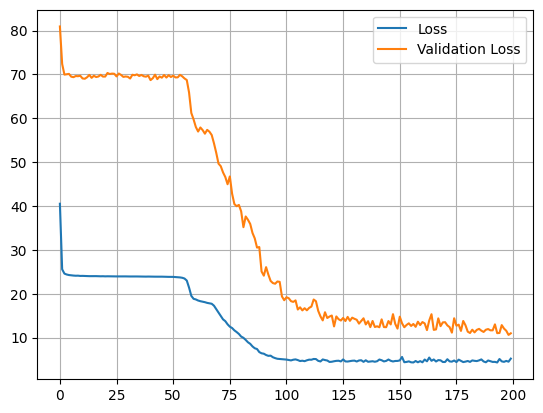

In [420]:
plt.plot(epoch_life, loss, label="Loss")
plt.plot(epoch_life, val_loss, label="Validation Loss")
plt.legend(loc=1)
plt.grid(True)
plt.show()

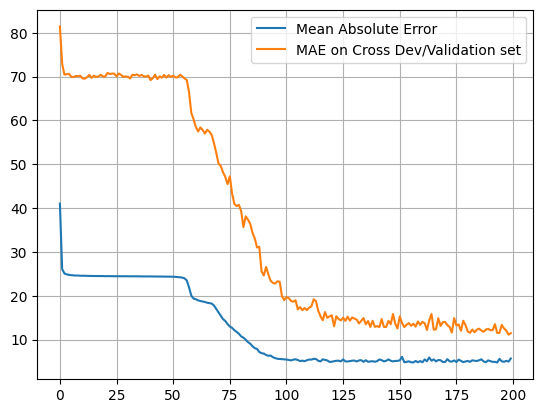

In [421]:
plt.plot(epoch_life, mae, label="Mean Absolute Error")
plt.plot(epoch_life, val_mae, label="MAE on Cross Dev/Validation set")
plt.grid(True)
plt.legend(loc=1)
plt.show()

In [422]:
# Checking layer weights:
print(l0.get_weights())

[array([[-0.53755116],
       [-0.20587373],
       [-0.51366985],
       [-0.290976  ],
       [ 0.08946019],
       [ 0.38971204],
       [-0.37327495],
       [ 0.46232924],
       [ 0.37815294],
       [ 0.3810466 ],
       [ 0.19960411],
       [ 0.18346542],
       [ 0.1995691 ],
       [-0.46073246],
       [ 0.40687817]], dtype=float32), array([0.00870286], dtype=float32)]


In [423]:
series = np.array(series)

In [424]:
# Checking out by forecasting for 1 window
start = split_time - window_size
output = model.predict(series[start:split_time][np.newaxis])
print("Actual Price: ${}".format(series[split_time]))
print("Predicted Price: ${}".format(output.squeeze()))

1/1 [==============================] - 0s 118ms/step
Actual Price: $148.38
Predicted Price: $160.384033203125


In [425]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

In [426]:
series_to_forecast = series[split_time-window_size:-1]
forecast = model_forecast(model, series_to_forecast, window_size, batch_size)
forecast = np.squeeze(forecast)

15/15 [==============================] - 0s 2ms/step


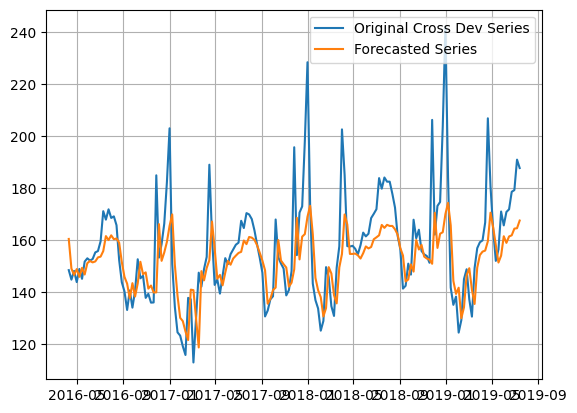

Mean Absolute Error for Forecasted Series: 10.853719711303711


In [427]:
plt.plot(time_valid, x_valid, label="Original Cross Dev Series")
plt.plot(time_valid, forecast, label="Forecasted Series")
plt.legend(loc=1)
plt.grid(True)
plt.show()

print("Mean Absolute Error for Forecasted Series: {}".format(tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()))

### Chores: 
To perform sanity check, normalize data, and optionally set a benchmark for the model using statistical methods